# **Model Training and Evaluation for Problem 3**

In this file, following the preprocessing steps performed in `PPQ3` and after preparing the data, model training has been carried out to find the best model for **Problem 3**.  
**Problem 3**: Suppose we need to predict the number of passengers in different time intervals for the next day, in order to allocate the appropriate number of trains more accurately.

At the end, the best models have been identified based on the evaluation metrics **RMSE** and **R²**.


 **Modeling Process Overview**

The workflow has been as follows: models were trained and the results of each model were saved.  
An important note is that, based on previous results, **only two models** — **XGBoost** and **LSTM** — have been evaluated.  
Also, **only the KNN imputation method** has been used for filling the null values.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input, LSTM, Concatenate, GRU, Masking, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint


In [3]:
rmse_results = {}
r2_results = {}

In [4]:
def sns_jointplot(y_pred, y_test):
  g = sns.jointplot(x=y_pred, y=y_test, kind='scatter')
  plt.xlabel('y_pred')
  plt.ylabel('y_label')
  if np.all(y_pred >= 0):
    g.ax_joint.set_xlim(0-1000, y_test.max()+1000)
  g.ax_joint.set_ylim(0-1000, y_test.max()+1000)
  plt.show()

In [5]:
X_train = pd.read_csv('data\Q3\X_train3.csv')
X_val = pd.read_csv('data\Q3\X_val3.csv')
X_test = pd.read_csv('data\Q3\X_test3.csv')
y_train = pd.read_csv('data\Q3\y_train3.csv').values.ravel()
y_val = pd.read_csv('data\Q3\y_val3.csv').values.ravel()
y_test = pd.read_csv('data\Q3\y_test3.csv').values.ravel()
y_test = np.round(np.expm1(y_test))

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(46516, 89) (2555, 89) (2160, 89)
(46516,) (2555,) (2160,)


## XGBoost

In [15]:
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', tree_method= 'gpu_hist', missing=-1)
param_grid = {
    'n_estimators': [100, 200, 500, 700, 1000],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 10, 13],
    'gamma': [0, 0.2]
    }
X_combined = np.concatenate([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])
train_indices = np.arange(len(X_train))
val_indices = np.arange(len(X_train), len(X_train) + len(X_val))
cv_split = [(train_indices, val_indices)]
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_split, scoring='neg_mean_squared_error', n_jobs=6)
grid_search.fit(X_combined, y_combined)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

joblib.dump(best_model, 'models_Q3\XGBoost_knn.joblib')

Best parameters: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 1000}


['models_Q3\\XGBoost_knn.joblib']

RMSE: 144.78904833763676
R^2: 0.979560169442027


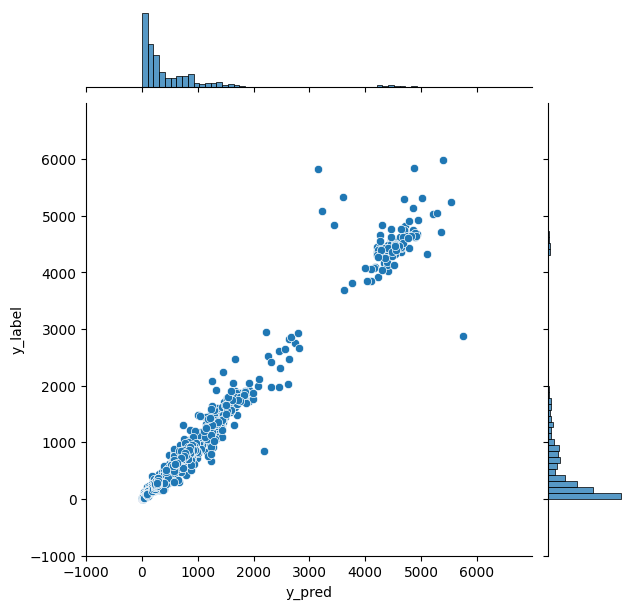

In [17]:
model_XGBoost = joblib.load('models_Q3\XGBoost_knn.joblib')


y_pred = model_XGBoost.predict(X_test)
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results['XGBoost'] = rmse
r2_results['XGBoost'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred, y_test)

## LSTM

In [18]:
seq_features = ['lag_7', 'lag_8', 'lag_9', 'lag_14', 'lag_21', 'lag_28']
seq_features

['lag_7', 'lag_8', 'lag_9', 'lag_14', 'lag_21', 'lag_28']

In [19]:
static_features = [col for col in X_train.columns if col not in seq_features]

In [20]:
X_seq_train = X_train[seq_features].values.reshape((len(X_train), len(seq_features), 1))
X_seq_val = X_val[seq_features].values.reshape((len(X_val), len(seq_features), 1))
X_seq_test = X_test[seq_features].values.reshape((len(X_test), len(seq_features), 1))

X_static_train = X_train[static_features].values
X_static_val = X_val[static_features].values
X_static_test = X_test[static_features].values

print("X_seq shape:", X_seq_train.shape)        
print("X_static shape:", X_static_train.shape) 


X_seq shape: (46516, 6, 1)
X_static shape: (46516, 83)


In [21]:
# Sequence
seq_input = Input(shape=(len(seq_features), 1))
x1 = LSTM(16, return_sequences=True)(seq_input)
x1 = LSTM(8)(x1)

# Static
static_input = Input(shape=(len(static_features),))
x2 = Dense(32, activation='tanh')(static_input)
x2 = Dropout(0.2)(x2)
x2 = Dense(16, activation='linear')(x2)
x2 = Dropout(0.1)(x2)
x2 = Dense(8, activation='linear')(x2)


# Concatenate
combined = Concatenate()([x1, x2])
xc = Dense(8, activation='relu')(combined)
xc = Dense(4, activation='relu')(xc)
output = Dense(1, activation='relu')(xc)

model = Model(inputs=[seq_input, static_input], outputs=output)
model.compile(optimizer='adam', loss='mse')


checkpoint = ModelCheckpoint(
    filepath='models_Q3/LSTM_knn.keras',
    monitor='val_loss',                        
    save_best_only=True,                        
    save_weights_only=False,                    
    mode='min',                              
    verbose=0                                  
)

history = model.fit([X_seq_train, X_static_train],
                    y_train,
                    epochs=50, batch_size=32,
                    validation_data=([X_seq_val, X_static_val], y_val),
                    callbacks=[checkpoint],
                    verbose=1,
                    )

Epoch 1/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 2.7377 - val_loss: 0.0978
Epoch 2/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1027 - val_loss: 0.0802
Epoch 3/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0917 - val_loss: 0.0783
Epoch 4/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0834 - val_loss: 0.0715
Epoch 5/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0745 - val_loss: 0.0667
Epoch 6/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0699 - val_loss: 0.0562
Epoch 7/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0661 - val_loss: 0.0534
Epoch 8/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0649 - val_loss: 0.0581
Epoch 9/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0636 - val_loss: 0.0505
Epoch 10/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0664 - val_loss: 0.0555
Epoch 11/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0617 - val_loss: 0.0500
Epoch 12/50
1454/1454 ━━━━━━━━

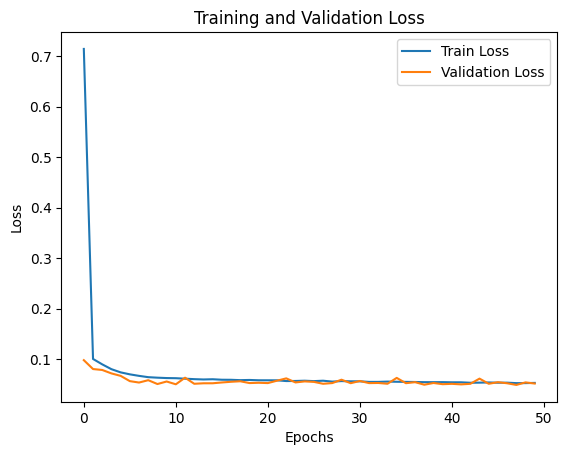

In [22]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
RMSE: 142.39292110734115
R^2: 0.9802310927941458


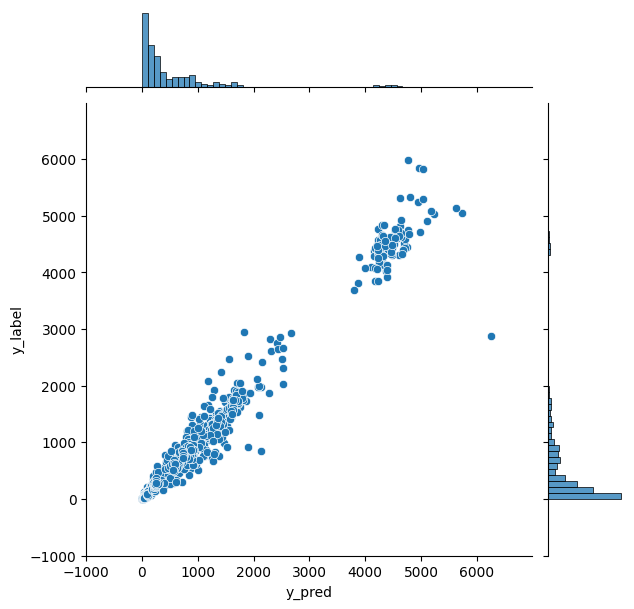

In [23]:
model_LSTM_ANN = load_model('models_Q3/LSTM_knn.keras')


y_pred = model_LSTM_ANN.predict([X_seq_test, X_static_test])
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results['LSTM'] = rmse
r2_results['LSTM'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred.reshape(y_test.shape[0]), y_test)


## Compare models

In [24]:
results_df = pd.DataFrame({
    'RMSE': rmse_results,
    'R2': r2_results
})

In [ ]:
results_df.to_csv('data/Q3/Summary/results.csv', index=False)

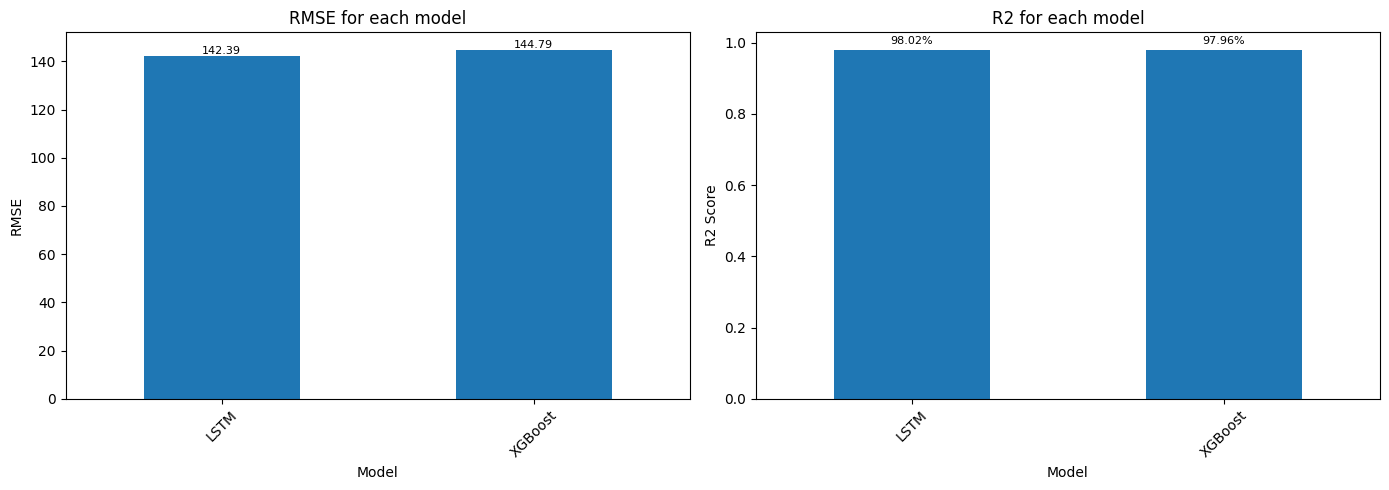

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

results_df['RMSE'].plot(kind='bar', ax=axes[0])
axes[0].set_title('RMSE for each model')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Model')
axes[0].tick_params(axis='x', rotation=45)

for i, v in enumerate(results_df['RMSE']):
    axes[0].text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=8)

results_df['R2'].plot(kind='bar', ax=axes[1])
axes[1].set_title('R2 for each model')
axes[1].set_ylabel('R2 Score')
axes[1].set_xlabel('Model')
axes[1].tick_params(axis='x', rotation=45)

for i, v in enumerate(results_df['R2']):
    axes[1].text(i, v + 0.01, f"{v*100:.2f}%", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


### **Result Analysis**

According to the obtained results, there is no significant difference between the two models, and neither can be clearly considered superior.  
However, an important point is the **98% accuracy**, which indicates that passenger numbers can be predicted almost perfectly.  
This demonstrates the **effectiveness of the models** used.



For RMSE, the lower the value, the less error the model has.  
For R², the higher the value, the more accurate the model is.